## Google Drive

In [1]:
import io
import os
import time
import requests
import speedtest
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload

# Setup Google Drive API
SCOPES = ['https://www.googleapis.com/auth/drive']
SERVICE_ACCOUNT_FILE = 'Account.json'

credentials = service_account.Credentials.from_service_account_file(
        SERVICE_ACCOUNT_FILE, scopes=SCOPES)

service = build('drive', 'v3', credentials=credentials)

# Function to upload file to Google Drive
def upload_to_gdrive(file_path):
    """
    Uploads a file to Google Drive and returns the file ID, size, and the time taken to complete the upload.

    Parameters:
        file_path (str): 
            The path to the file that needs to be uploaded.

    Returns:
        tuple: 
            - file_id (str): The ID of the uploaded file in Google Drive.
            - file_size (int): The size of the uploaded file in bytes.
            - upload_time (float): The time taken to upload the file in seconds.
    """

    start_time = time.time()
    file_metadata = {'name': os.path.basename(file_path)}
    media = MediaFileUpload(file_path, mimetype='application/octet-stream')
    file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()
    end_time = time.time()
    file_size = os.path.getsize(file_path)
    return file.get('id'), file_size, end_time - start_time

# Function to download file from Google Drive
def download_from_gdrive(file_id, destination):
    """
    Downloads a file from Google Drive and returns the size of the downloaded file and the time taken to complete the download.

    Parameters:
        file_id (str): 
            The ID of the file to be downloaded from Google Drive.
        destination (str): 
            The destination path where the downloaded file should be saved.

    Returns:
        tuple: 
            - file_size (int): The size of the downloaded file in bytes.
            - download_time (float): The time taken to download the file in seconds.
    """

    start_time = time.time()
    request = service.files().get_media(fileId=file_id)
    fh = io.FileIO(destination, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
    end_time = time.time()
    file_size = os.path.getsize(destination)
    return file_size, end_time - start_time

# Function to delete file from Google Drive
def delete_from_gdrive(file_id):
    """
    Deletes a file from Google Drive using its file ID.

    Parameters:
        file_id (str): 
            The ID of the file to be deleted from Google Drive.

    Returns:
        None
    """
    service.files().delete(fileId=file_id).execute()
    print(f"File with ID {file_id} deleted from Google Drive.")

## Pinata IPFS

In [2]:
import requests

PINATA_API_KEY = '41447cb8e9c4ac5f0c37'
PINATA_SECRET_API_KEY = 'a5033aa1f0e41a6ddd151e479100548920780a21b9c0ad0e9d196d52c0676a44'

# Function to upload file to Pinata IPFS
def upload_to_pinata(file_path):
    """
    Uploads a file to Pinata IPFS and returns the IPFS hash, file size, and the time taken to complete the upload.

    Parameters:
        file_path (str): 
            The path to the file that needs to be uploaded.

    Returns:
        tuple: 
            - ipfs_hash (str): The IPFS hash of the uploaded file.
            - file_size (int): The size of the uploaded file in bytes.
            - upload_time (float): The time taken to upload the file in seconds.
    """

    start_time = time.time()
    url = "https://api.pinata.cloud/pinning/pinFileToIPFS"
    headers = {
        "pinata_api_key": PINATA_API_KEY,
        "pinata_secret_api_key": PINATA_SECRET_API_KEY
    }
    with open(file_path, 'rb') as file:
        response = requests.post(url, files={"file": file}, headers=headers)
    end_time = time.time()
    file_size = os.path.getsize(file_path)
    return response.json().get('IpfsHash'), file_size, end_time - start_time

# Function to download file from Pinata IPFS
def download_from_pinata(ipfs_hash, destination):
    """
    Downloads a file from Pinata IPFS using its IPFS hash and returns the size of the downloaded file and the time taken to complete the download.

    Parameters:
        ipfs_hash (str): 
            The IPFS hash of the file to be downloaded.
        destination (str): 
            The destination path where the downloaded file should be saved.

    Returns:
        tuple: 
            - file_size (int): The size of the downloaded file in bytes.
            - download_time (float): The time taken to download the file in seconds.
    """

    start_time = time.time()
    url = f"https://gateway.pinata.cloud/ipfs/{ipfs_hash}"
    response = requests.get(url)
    with open(destination, 'wb') as file:
        file.write(response.content)
    end_time = time.time()
    file_size = os.path.getsize(destination)
    return file_size, end_time - start_time

# Function to delete file from Pinata IPFS
def delete_from_pinata(ipfs_hash):
    """
    Deletes a file from Pinata IPFS using its IPFS hash.

    Parameters:
        ipfs_hash (str): 
            The IPFS hash of the file to be deleted from Pinata IPFS.

    Returns:
        None

    This function prints a success message if the file is deleted successfully or an error message if the deletion fails.
    """

    url = f"https://api.pinata.cloud/pinning/unpin/{ipfs_hash}"
    headers = {
        "pinata_api_key": PINATA_API_KEY,
        "pinata_secret_api_key": PINATA_SECRET_API_KEY
    }
    response = requests.delete(url, headers=headers)
    if response.status_code == 200:
        print(f"File with IPFS hash {ipfs_hash} deleted from Pinata IPFS.")
    else:
        print(f"Failed to delete file with IPFS hash {ipfs_hash} from Pinata IPFS. Status code: {response.status_code}")

In [3]:
# Function to measure network speed
def get_network_speed():
    """
    Measures the current network speed for download and upload using the `speedtest` library.

    Parameters:
        None

    Returns:
        tuple:
            - download_speed (float): The download speed in Megabits per second (Mbps).
            - upload_speed (float): The upload speed in Megabits per second (Mbps).
    """

    st = speedtest.Speedtest()
    download_speed = st.download() / 10**6  # Convert to Mbps
    upload_speed = st.upload() / 10**6  # Convert to Mbps
    return download_speed, upload_speed

## Comparision Function

In [4]:
# Function to compare storage services (Google Drive and Pinata IPFS)
def compare_storage_services(file_path, destination_gdrive, destination_pinata):
    """
    Compares the performance of two storage services, Google Drive and Pinata IPFS, by measuring file upload and download times, and returns a summary of the results.

    Parameters:
        file_path (str): 
            The path to the file that will be uploaded to both storage services.
        destination_gdrive (str): 
            The destination path where the file downloaded from Google Drive will be saved.
        destination_pinata (str): 
            The destination path where the file downloaded from Pinata IPFS will be saved.

    Returns:
        pandas.DataFrame:
            A DataFrame summarizing the comparison results, including file size, upload time, download time, and network speed for both services.
    """

    # Measure network speed
    download_speed, upload_speed = get_network_speed()

    # Google Drive
    gdrive_file_id, gdrive_file_size, gdrive_upload_time = upload_to_gdrive(file_path)
    gdrive_downloaded_size, gdrive_download_time = download_from_gdrive(gdrive_file_id, destination_gdrive)

    # Pinata IPFS
    pinata_ipfs_hash, pinata_file_size, pinata_upload_time = upload_to_pinata(file_path)
    pinata_downloaded_size, pinata_download_time = download_from_pinata(pinata_ipfs_hash, destination_pinata)

    # Delete the uploaded file from Google Drive
    delete_from_gdrive(gdrive_file_id)

    # Delete the uploaded file from Pinata IPFS
    delete_from_pinata(pinata_ipfs_hash)

    # Convert sizes to MB
    gdrive_file_size_mb = gdrive_file_size / 10**6
    gdrive_downloaded_size_mb = gdrive_downloaded_size / 10**6
    pinata_file_size_mb = pinata_file_size / 10**6
    pinata_downloaded_size_mb = pinata_downloaded_size / 10**6

    # Create a DataFrame to store the results
    data = {
        'Service': ['Google Drive', 'Pinata IPFS'],
        'File Size (MB)': [gdrive_file_size_mb, pinata_file_size_mb],
        'Upload Time (s)': [gdrive_upload_time, pinata_upload_time],
        'Download Time (s)': [gdrive_download_time, pinata_download_time],
        'Downloaded Size (MB)': [gdrive_downloaded_size_mb, pinata_downloaded_size_mb],
        'Network Download Speed (Mbps)': [download_speed, download_speed],
        'Network Upload Speed (Mbps)': [upload_speed, upload_speed]
    }

    df = pd.DataFrame(data)
    return df

## Visualization Function

In [5]:
# Function to visualize the comparison results
def visualize_comparison(df):
    """
    Visualizes the comparison results of different storage services using bar plots, including comparisons of file size, upload time, download time, and network speed.

    Parameters:
        df (pandas.DataFrame): 
            A DataFrame containing the comparison results, with columns for service name, file size, upload time, download time, and network speed.

    Returns:
        None

    This function generates the following visualizations:
        1. File Size Comparison: A bar plot comparing the file sizes uploaded to different services.
        2. Upload Time Comparison: A bar plot comparing the time taken to upload the file to different services.
        3. Download Time Comparison: A bar plot comparing the time taken to download the file from different services.
        4. Network Speed Comparison: A bar plot comparing the network download speeds during the tests for different services.

    All plots are displayed together in a 2x2 grid layout.
    """

    sns.set(style="whitegrid")
    plt.figure(figsize=(16, 10))

    # File Size Comparison
    plt.subplot(2, 2, 1)
    sns.barplot(x='Service', y='File Size (MB)', hue='Service', data=df, palette="viridis", dodge=False)
    plt.title('File Size Comparison')
    plt.xlabel('Service')
    plt.ylabel('File Size (MB)')
    plt.legend([],[], frameon=False)

    # Upload Time Comparison
    plt.subplot(2, 2, 2)
    sns.barplot(x='Service', y='Upload Time (s)', hue='Service', data=df, palette="viridis", dodge=False)
    plt.title('Upload Time Comparison')
    plt.xlabel('Service')
    plt.ylabel('Upload Time (s)')
    plt.legend([],[], frameon=False)

    # Download Time Comparison
    plt.subplot(2, 2, 3)
    sns.barplot(x='Service', y='Download Time (s)', hue='Service', data=df, palette="viridis", dodge=False)
    plt.title('Download Time Comparison')
    plt.xlabel('Service')
    plt.ylabel('Download Time (s)')
    plt.legend([],[], frameon=False)

    # Network Speed Comparison
    plt.subplot(2, 2, 4)
    sns.barplot(x='Service', y='Network Download Speed (Mbps)', hue='Service', data=df, palette="viridis", dodge=False)
    plt.title('Network Download Speed Comparison')
    plt.xlabel('Service')
    plt.ylabel('Download Speed (Mbps)')
    plt.legend([],[], frameon=False)

    plt.tight_layout()
    plt.show()

In [6]:
# Main execution section
file_path = 'First1m.csv'
destination_gdrive = 'First1m.csv'
destination_pinata = 'First1m.csv'

# Compare storage services and get the DataFrame
comparison_df = compare_storage_services(file_path, destination_gdrive, destination_pinata)

File with ID 1vI39XcXjyQmMxj-kPgq9jVLE1PJT290Y deleted from Google Drive.
File with IPFS hash QmcxYiVeU3ziuK7qwcUdiXRfVpTK8GojYtNnXGU8axeik2 deleted from Pinata IPFS.


In [7]:
comparison_df

,Service,File Size (MB),Upload Time (s),Download Time (s),Downloaded Size (MB),Network Download Speed (Mbps),Network Upload Speed (Mbps)
0,Google Drive,255.590646,8.943883,13.716544,255.590646,724.117557,229.942013
1,Pinata IPFS,255.590646,8.858901,3.325331,255.590646,724.117557,229.942013


# Visualization

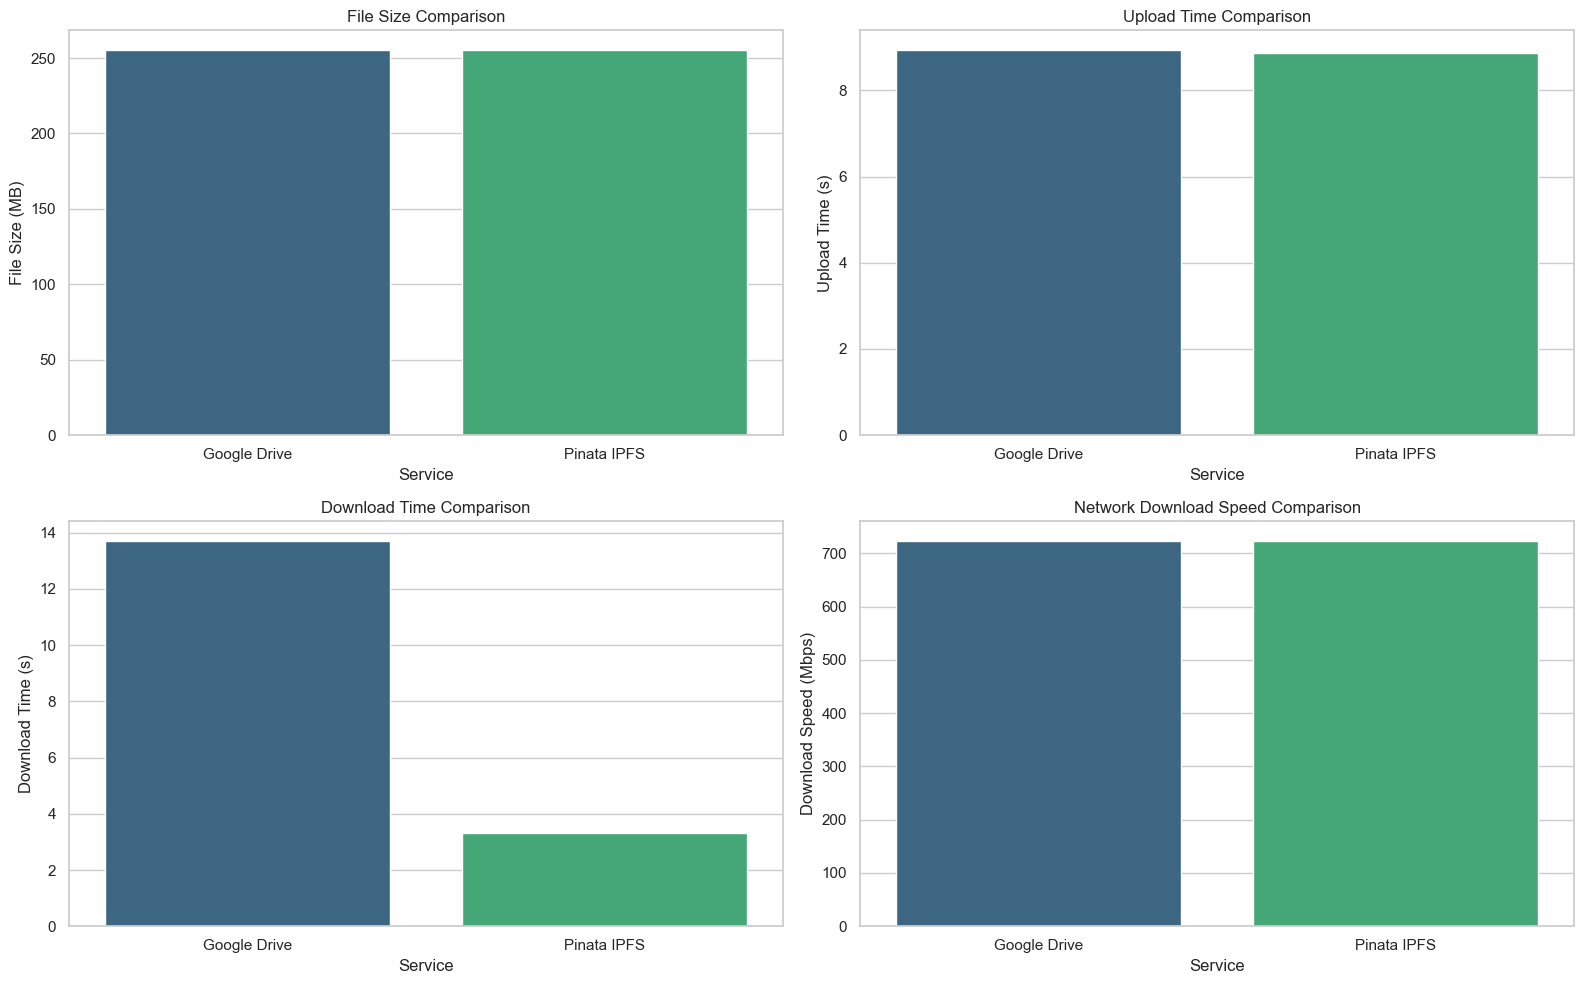

In [8]:
# Visualize the comparison
visualize_comparison(comparison_df)